# OSMnx Library Introduction

---

## Import the library and make a first example

In the next code space I just import the OSMnx library and in the next code space you can find the first example on how to use OSMnx.

In [1]:
# Importing the useful libraries

import osmnx as ox
import matplotlib

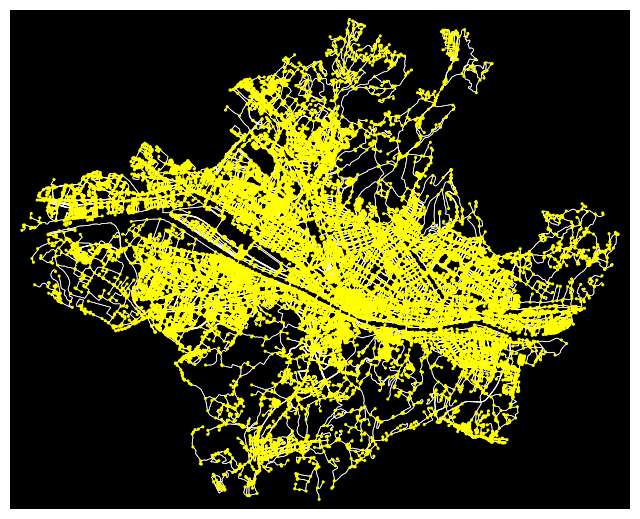

In [2]:
# Searches on OpenStreetMap the place it indicates (in this case "Florence, Italy"),
# downloads the road network of that area,
# builds a graph where:
# - the nodes are intersections, points of interest, etc.
# - the edges are the road segments that connect the nodes.
# - walk = walkable streets

graph = ox.graph_from_place("Florence, Italy", network_type="walk")

fig, ax = ox.plot_graph(
    graph,
    node_color='yellow',
    node_size=5,
    edge_color='white',
    edge_linewidth=0.5,
    bgcolor='black'
)